## A practical introduction 

source: http://adilmoujahid.com/posts/2016/06/introduction-deep-learning-python-caffe/

### prerequisite
caffe
numpy
cv2
pip install lmdb


## preparation of data

follow the source code: https://github.com/adilmoujahid/deeplearning-cats-dogs-tutorial/blob/master/code/create_lmdb.py

In [9]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# notice must import caffe before print_helper, since it will do something on all attributes on a class.
# then the methods I inject into class, such as p or pp, will impect the caffe.
import caffe
from caffe.proto import caffe_pb2
import lmdb
import numpy as np
import print_helper
import os
DATA_PATH = "./data"
train_data_path = os.path.join(DATA_PATH,'train')
test_data_path = os.path.join(DATA_PATH,'test1')

### see the images

In [4]:
import cv2

IMAGE_WIDTH = 227
IMAGE_HEIGHT = 227
def transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT):
    #Histogram Equalization
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])

    #Image Resizing
    img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)

    return img    

/home/colin/work/caffe_examples/dog_cat
Original image:


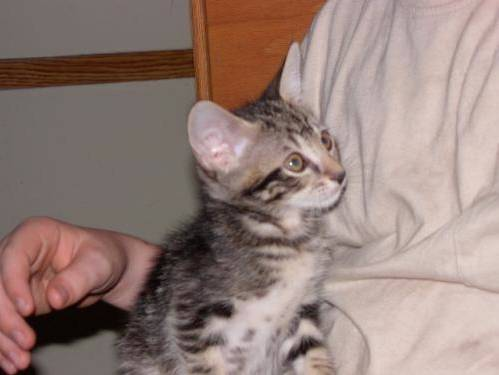

In [7]:
import IPython
display_image = IPython.display.Image
!pwd

test_image_path = './data/train/cat.1247.jpg'
print("Original image:")
display_image(filename=test_image_path)

(-0.5, 498.5, 374.5, -0.5)

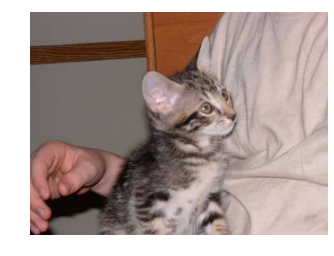

In [11]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt

test_image_bgr = cv2.imread(test_image_path, cv2.IMREAD_COLOR)
test_image = cv2.cvtColor(test_image_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(test_image)
plt.axis('off')



(-0.5, 226.5, 226.5, -0.5)

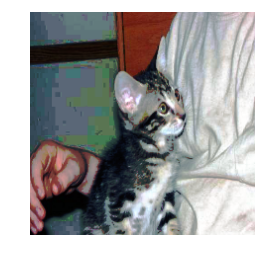

In [14]:
transformed_test_image = transform_img(test_image)
plt.imshow(transformed_test_image)
plt.axis('off')

### load images

In [8]:
# load images
import glob
import random
random.seed(2)
all_train_data = [img_path for img_path in glob.glob(train_data_path+"/*jpg")]
test_data = [img_path for img_path in glob.glob(test_data_path+"/*jpg")]
len(all_train_data).p()
all_train_data[0].p()
len(all_train_data).p()
#Shuffle train_data
random.shuffle(all_train_data)
all_train_data[0].p()
validation_count = len(all_train_data) / 5
train_data = all_train_data[0:len(all_train_data)-validation_count]
validation_data = all_train_data[len(all_train_data)-validation_count:]
# train_data = all_train_data[0:12500]
# validation_data = all_train_data[12500:15000]

len(train_data).p()
len(validation_data).p()

len(all_train_data) : 25000
all_train_data[0] : ./data/train/dog.4728.jpg
len(all_train_data) : 25000
all_train_data[0] : ./data/train/dog.10522.jpg
len(train_data) : 20000
len(validation_data) : 5000


5000

### create train lmdb

In [6]:
import caffe
from caffe.proto import caffe_pb2
import lmdb
def make_datum(img, label):
    #image is numpy.ndarray format. BGR instead of RGB
    return caffe_pb2.Datum(
        channels=3,
        width=IMAGE_WIDTH,
        height=IMAGE_HEIGHT,
        label=label,
        data=np.rollaxis(img, 2).tostring())

def write_to_lmdb(lmdb_path, the_data):
    in_db = lmdb.open(lmdb_path, map_size=int(1e12))
    with in_db.begin(write=True) as in_txn:
        for in_idx, img_path in enumerate(the_data):
            if in_idx % 6 != 0:
                continue
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT)
            if 'cat' in img_path:
                label = 0
            else:
                label = 1
            datum = make_datum(img, label)
            in_txn.put('{:0>5d}'.format(in_idx), datum.SerializeToString())
            #print '{:0>5d}'.format(in_idx) + ':' + img_path
    in_db.close()       

In [7]:
train_lmdb_path = os.path.join(DATA_PATH,'train.lmdb')
validation_lmdb_path = os.path.join(DATA_PATH,'validation.lmdb')
write_to_lmdb(train_lmdb_path, train_data)
write_to_lmdb(validation_lmdb_path, validation_data)

run it in shell
generate the mean value for all images, it's a quite small file.

/opt/caffe/build/tools/compute_image_mean -backend=lmdb /home/colin/work/caffe_examples/dog_cat/data/train.lmdb /home/colin/work/caffe_examples/dog_cat/data/mean.binaryproto

In [16]:
mean_binary_path = os.path.join(DATA_PATH,'mean.binaryproto')

## Model Definition

In [12]:
import caffe
from caffe import layers as L, params as P


def alex_net_1(lmdb_path, batch_size, mean_file_path, has_accuracy=False):
    the_param = [dict(lr_mult=1,decay_mult=1),dict(lr_mult=2,decay_mult=0)]

    # our version of LeNet: a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()

    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb_path,
            transform_param=dict(mirror=True,crop_size=227,mean_file=mean_file_path), 
            ntop=2)
    
    n.conv1 = L.Convolution(n.data, num_output=96, kernel_size=11, stride=4, 
            weight_filler=dict(type='gaussian',std=0.01),
            bias_filler=dict(type='constant',value=0),
            param=the_param)
    n.relu1 = L.ReLU(n.conv1, in_place=True)
    n.pool1 = L.Pooling(n.relu1, kernel_size=3, stride=2, pool=P.Pooling.MAX)
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=0.0001, beta=0.75)

    n.conv2 = L.Convolution(n.norm1, num_output=256, kernel_size=5, pad=2, group=2,
            weight_filler=dict(type='gaussian',std=0.01),
            bias_filler=dict(type='constant',value=0),
            param=the_param)
    n.relu2 = L.ReLU(n.conv2, in_place=True)
    n.pool2 = L.Pooling(n.relu2, kernel_size=3, stride=2, pool=P.Pooling.MAX)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=0.0001, beta=0.75)

    # why this conv3 is not group=2
    n.conv3 = L.Convolution(n.norm2, num_output=384, kernel_size=3, pad=1,
            weight_filler=dict(type='gaussian',std=0.01),
            bias_filler=dict(type='constant',value=0),
            param=the_param)
    n.relu3 = L.ReLU(n.conv3, in_place=True)

    n.conv4 = L.Convolution(n.relu3, num_output=384, kernel_size=3, pad=1, group=2,
            weight_filler=dict(type='gaussian',std=0.01),
            bias_filler=dict(type='constant',value=0),
            param=the_param)
    n.relu4 = L.ReLU(n.conv4, in_place=True)

    n.conv5 = L.Convolution(n.relu4, num_output=256, kernel_size=3, pad=1, group=2,
            weight_filler=dict(type='gaussian',std=0.01),
            bias_filler=dict(type='constant',value=0),
            param=the_param)
    n.relu5 = L.ReLU(n.conv5, in_place=True)
    n.pool5 = L.Pooling(n.relu5, kernel_size=3, stride=2, pool=P.Pooling.MAX)

    n.fc6 =   L.InnerProduct(n.pool5, num_output=4096,
            weight_filler=dict(type='gaussian',std=0.005),
            bias_filler=dict(type='constant',value=1),
            param=the_param)
    n.relu6 = L.ReLU(n.fc6, in_place=True)
    n.drop6 = L.Dropout(n.relu6, in_place=True, dropout_ratio=0.5)

    n.fc7 =   L.InnerProduct(n.drop6, num_output=4096,
            weight_filler=dict(type='gaussian',std=0.005),
            bias_filler=dict(type='constant',value=1),
            param=the_param)
    n.relu7 = L.ReLU(n.fc7, in_place=True)
    n.drop7 = L.Dropout(n.relu7, in_place=True, dropout_ratio=0.5)

    n.fc8 =   L.InnerProduct(n.drop7, num_output=2,
            weight_filler=dict(type='gaussian',std=0.01),
            bias_filler=dict(type='constant',value=0),
            param=the_param)
    if has_accuracy:
        n.accuracy = L.Accuracy(n.fc8, n.label)
    n.loss =  L.SoftmaxWithLoss(n.fc8, n.label)
    
    return n.to_proto()


In [9]:
def write_to_file(the_path, the_content):
    with open(the_path,'w') as the_f:
        the_f.write(the_content)
    return the_content

In [2]:
train_proto = str(alex_net_1(train_lmdb_path, 256, mean_binary_path))
# print train_proto
validation_proto = str(alex_net_1(validation_lmdb_path, 50, mean_binary_path))

train_proto_path = 'train.prototxt'
validation_proto_path = 'validation.prototxt'

write_to_file(train_proto_path, train_proto)
write_to_file(validation_proto_path, validation_proto);

NameError: name 'alex_net_1' is not defined

### for VGG 16

In [11]:
# https://gist.github.com/ksimonyan/211839e770f7b538e2d8#file-readme-md

# http://caffe.berkeleyvision.org/tutorial/layers.html
import caffe
from caffe import layers as L, params as P


def vgg_16(lmdb_path, batch_size, mean_file_path):
    the_param = [dict(lr_mult=1,decay_mult=1),dict(lr_mult=2,decay_mult=0)]

    # our version of LeNet: a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()

    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb_path,
            transform_param=dict(mirror=True,crop_size=227,mean_file=mean_file_path), 
            ntop=2)
    
    n.conv1_1 = L.Convolution(n.data, num_output=64, kernel_size=3, pad=1)
    n.relu1_1 = L.ReLU(n.conv1_1, in_place=True)
    n.conv1_2 = L.Convolution(n.relu1_1, num_output=64, kernel_size=3, pad=1)
    n.relu1_2 = L.ReLU(n.conv1_2, in_place=True)
    n.pool1 = L.Pooling(n.relu1_2, kernel_size=2, stride=2, pool=P.Pooling.MAX)

    n.conv2_1 = L.Convolution(n.pool1, num_output=128, kernel_size=3, pad=1)
    n.relu2_1 = L.ReLU(n.conv2_1, in_place=True)
    n.conv2_1 = L.Convolution(n.relu2_1, num_output=128, kernel_size=3, pad=1)
    n.relu2_2 = L.ReLU(n.conv2_1, in_place=True)
    n.pool2 = L.Pooling(n.relu2_2, kernel_size=2, stride=2, pool=P.Pooling.MAX)

    n.conv3_1 = L.Convolution(n.pool2, num_output=256, kernel_size=3, pad=1)
    n.relu3_1 = L.ReLU(n.conv3_1, in_place=True)
    n.conv3_2 = L.Convolution(n.relu3_1, num_output=256, kernel_size=3, pad=1)
    n.relu3_2 = L.ReLU(n.conv3_2, in_place=True)
    n.conv3_3 = L.Convolution(n.relu3_2, num_output=256, kernel_size=3, pad=1)
    n.relu3_3 = L.ReLU(n.conv3_3, in_place=True)
    n.pool3 = L.Pooling(n.relu3_3, kernel_size=2, stride=2, pool=P.Pooling.MAX)

    n.conv4_1 = L.Convolution(n.pool3, num_output=512, kernel_size=3, pad=1)
    n.relu4_1 = L.ReLU(n.conv4_1, in_place=True)
    n.conv4_2 = L.Convolution(n.relu4_1, num_output=512, kernel_size=3, pad=1)
    n.relu4_2 = L.ReLU(n.conv4_2, in_place=True)
    n.conv4_3 = L.Convolution(n.relu4_2, num_output=512, kernel_size=3, pad=1)
    n.relu4_3 = L.ReLU(n.conv4_3, in_place=True)
    n.pool4 = L.Pooling(n.relu4_3, kernel_size=2, stride=2, pool=P.Pooling.MAX)

    n.conv5_1 = L.Convolution(n.pool4, num_output=512, kernel_size=3, pad=1)
    n.relu5_1 = L.ReLU(n.conv5_1, in_place=True)
    n.conv5_2 = L.Convolution(n.relu5_1, num_output=512, kernel_size=3, pad=1)
    n.relu5_2 = L.ReLU(n.conv5_2, in_place=True)
    n.conv5_3 = L.Convolution(n.relu5_2, num_output=512, kernel_size=3, pad=1)
    n.relu5_3 = L.ReLU(n.conv5_3, in_place=True)
    n.pool5 = L.Pooling(n.relu5_3, kernel_size=2, stride=2, pool=P.Pooling.MAX)


    n.fc6 =   L.InnerProduct(n.pool5, num_output=4096)
    n.relu6 = L.ReLU(n.fc6, in_place=True)
    n.drop6 = L.Dropout(n.relu6, in_place=True, dropout_ratio=0.5)

    n.fc7 =   L.InnerProduct(n.drop6, num_output=4096)
    n.relu7 = L.ReLU(n.fc7, in_place=True)
    n.drop7 = L.Dropout(n.relu7, in_place=True, dropout_ratio=0.5)

    # this changes for dog and cat
    n.fc8 =   L.InnerProduct(n.drop7, num_output=2)
    # if has_accuracy:
    #     n.accuracy = L.Accuracy(n.fc8, n.label)

    n.loss =  L.SoftmaxWithLoss(n.fc8, n.label)
    
    return n.to_proto()

import os
DATA_PATH = "./data"
mean_binary_path = os.path.join(DATA_PATH,'mean.binaryproto')
train_lmdb_path = os.path.join(DATA_PATH,'train.lmdb')
validation_lmdb_path = os.path.join(DATA_PATH,'validation.lmdb')

train_proto = str(vgg_16(train_lmdb_path, 256, mean_binary_path))
# print train_proto
validation_proto = str(vgg_16(validation_lmdb_path, 50, mean_binary_path))

train_proto_path = 'train_vgg_16.prototxt'
validation_proto_path = 'validation_vgg_16.prototxt'

write_to_file(train_proto_path, train_proto)
write_to_file(validation_proto_path, validation_proto);


In [2]:
from caffe.proto import caffe_pb2

def gen_solver():
    solver = caffe_pb2.SolverParameter()
    solver.train_net= "train.prototxt"
    solver.test_net.extend(["validation.prototxt"])
    solver.test_iter.extend([1000])
    solver.test_interval= 1000
    solver.base_lr= 0.001
    solver.lr_policy= "step"
    solver.gamma= 0.1
    solver.stepsize= 2500
    solver.display= 50
    solver.max_iter= 40000
    solver.momentum= 0.9
    solver.weight_decay= 0.0005
    #solver.snapshot= 5000
    #solver.snapshot_prefix= "snapshots"
    solver.solver_mode= solver.CPU
    return str(solver)

# for this case, if using Gpu, need 3G memory
solver_proto_str = gen_solver()
solver_proto_path = 'solver.prototxt'
write_to_file(solver_proto_path, solver_proto_str);

/opt/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/opt/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/opt/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


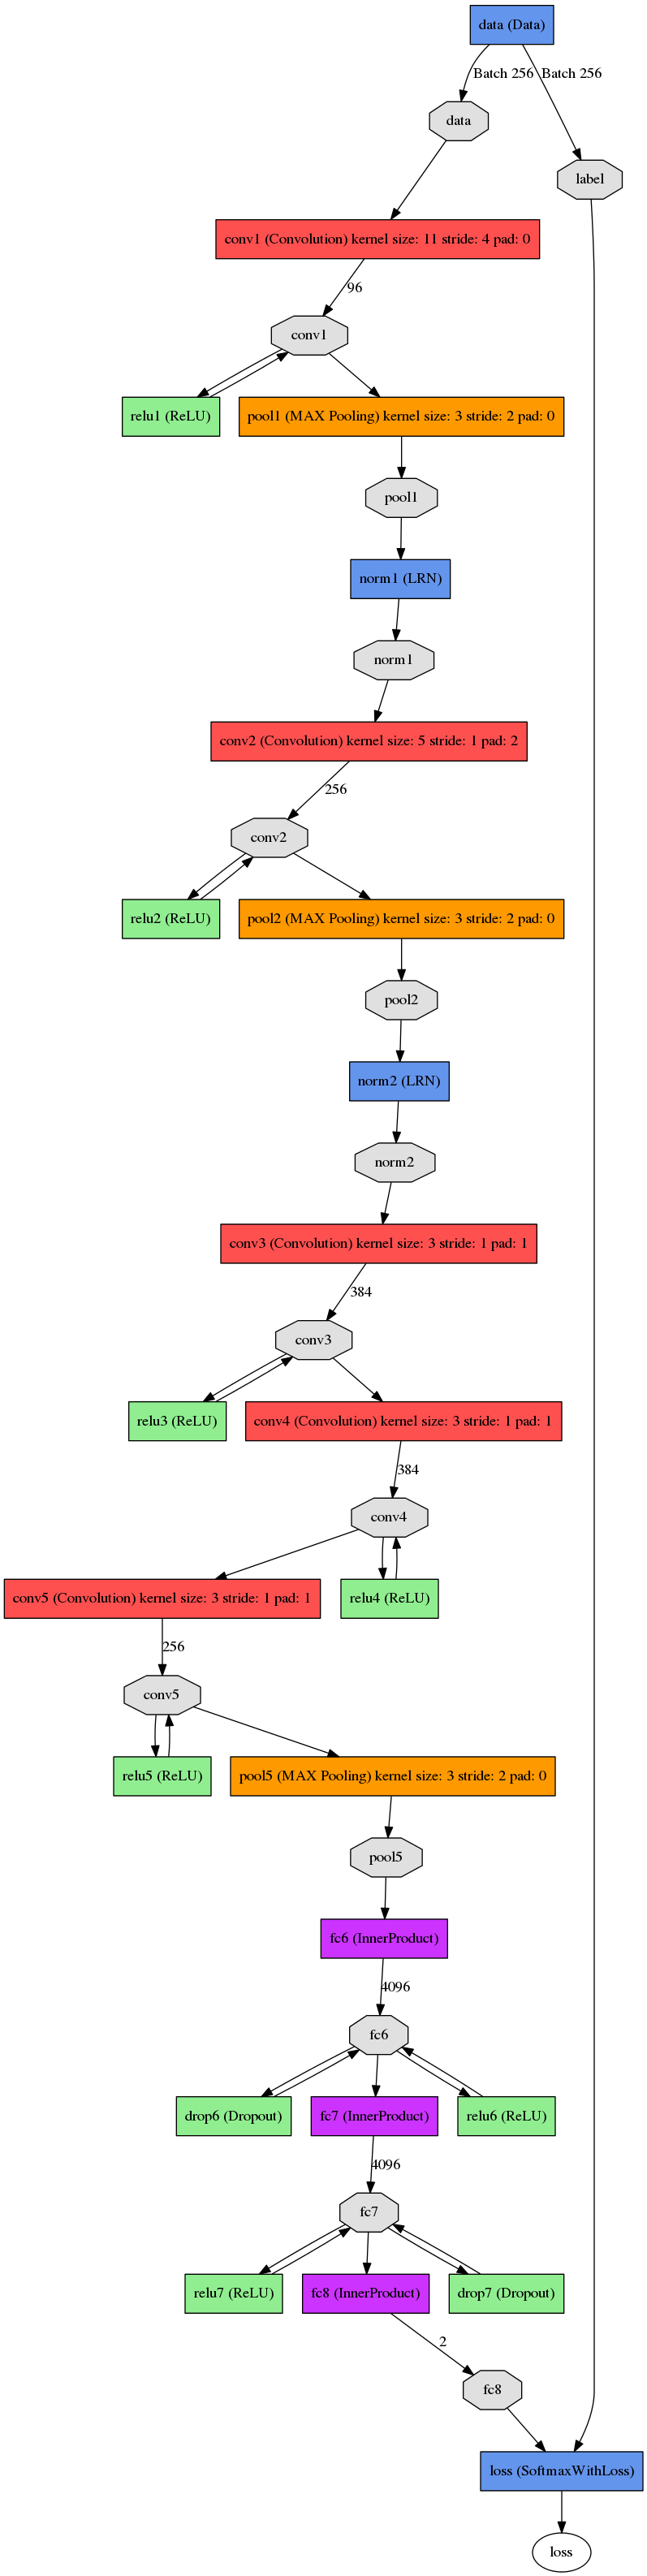

In [6]:
# sudo apt-get install Graphviz
from google.protobuf import text_format

import caffe
import caffe.draw
from caffe.proto import caffe_pb2

net = caffe_pb2.NetParameter()
train_proto_path = 'train.prototxt'
text_format.Merge(open(train_proto_path).read(), net)
net_image_path = 'net.png'
caffe.draw.draw_net_to_file(net, net_image_path, "TB")

# print net

import IPython
display_image = IPython.display.Image

display_image(filename=net_image_path)


In [1]:
import caffe
# caffe.set_device(0)
# caffe.set_mode_gpu()

solver_proto_path = "solver.prototxt"
### load the solver and create train and test nets
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver = caffe.SGDSolver(solver_proto_path)

# solver.p()
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

/opt/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/opt/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/opt/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


[('data', (256, 3, 227, 227)),
 ('label', (256,)),
 ('conv1', (256, 96, 55, 55)),
 ('pool1', (256, 96, 27, 27)),
 ('norm1', (256, 96, 27, 27)),
 ('conv2', (256, 256, 27, 27)),
 ('pool2', (256, 256, 13, 13)),
 ('norm2', (256, 256, 13, 13)),
 ('conv3', (256, 384, 13, 13)),
 ('conv4', (256, 384, 13, 13)),
 ('conv5', (256, 256, 13, 13)),
 ('pool5', (256, 256, 6, 6)),
 ('fc6', (256, 4096)),
 ('fc7', (256, 4096)),
 ('fc8', (256, 2)),
 ('loss', ())]

In [ ]:
%%time
# solver.net.forward()  # train net
# solver.test_nets[0].forward()
solver.step(1)

In [20]:
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (96, 3, 11, 11)),
 ('conv2', (256, 48, 5, 5)),
 ('conv3', (384, 256, 3, 3)),
 ('conv4', (384, 192, 3, 3)),
 ('conv5', (256, 192, 3, 3)),
 ('fc6', (4096, 9216)),
 ('fc7', (4096, 4096)),
 ('fc8', (2, 4096))]

(3, 227, 227)
(3, 227, 227)


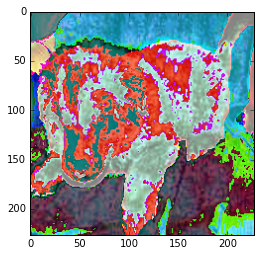

In [98]:
# solver.net.blobs['data'].channels.p()
# solver.net.blobs['data'].count.p()
# solver.net.blobs['data'].data.shape.p()
# solver.net.blobs['data'].diff.shape.p()
# solver.net.blobs['data'].height.p()
# solver.net.blobs['data'].num.p()

%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import print_helper
import numpy

# BGR instead of RGB
# test_image_bgr = solver.net.blobs['data'].data[0]
# numpy.save('test_image.npy',test_image_bgr)
test_image_bgr = numpy.load('test_image.npy')
# print test_image_bgr[0]
# print test_image_bgr.shape
# test_image_bgr = test_image_bgr.transpose(2,0,1)
# print test_image_bgr.shape
# # print test_image_bgr[:,:,0]
# test_image = cv2.cvtColor(test_image_bgr, cv2.COLOR_RGB2BGR)
# plt.imshow(test_image_bgr[:,:,:],cmap='gray')
# plt.axis('off')
# print dir(solver.net)
test_image = test_image_bgr
# raw_scale
test_image /= 255
# for channel
print test_image_bgr.shape
test_image = test_image[[2,1,0],:,:]
print test_image_bgr.shape
test_image = test_image.transpose(1, 2, 0)
# plt.imshow(test_image[:,:,0])
plt.imshow(test_image)

# re_image = transformer.deprocess('data',test_image_bgr)
# plt.imshow(re_image)

# solver.net.blobs['data'].data[0,0].pp();
# solver.net.blobs['data'].diff[0,0].pp();
# count, channels, data, diff, height, num

In [69]:
# import os
# # mean_binary_path = os.path.join(DATA_PATH,'mean.binaryproto')
# mu = numpy.load('data/mean.binaryproto')
# mu = mu.mean(1).mean(1)

transformer = caffe.io.Transformer({'data': solver.net.blobs['data'].data.shape})
print(solver.net.blobs['data'].data.shape)

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
# transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))

(256, 3, 227, 227)


(227, 227, 3)


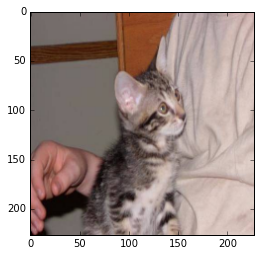

In [38]:
test_image_path = './data/train/cat.1247.jpg'
image = caffe.io.load_image(test_image_path)
transformed_image = transformer.preprocess('data', image)
re_image = transformer.deprocess('data',transformed_image)
# plt.imshow(image)
print re_image.shape
# plt.imshow(transformed_image.transpose(1,2,0))
plt.imshow(re_image)

In [101]:
[(k, v[0].data.shape) for k, v in solver.test_nets[0].params.items()]

[('conv1', (96, 3, 11, 11)),
 ('conv2', (256, 48, 5, 5)),
 ('conv3', (384, 256, 3, 3)),
 ('conv4', (384, 192, 3, 3)),
 ('conv5', (256, 192, 3, 3)),
 ('fc6', (4096, 9216)),
 ('fc7', (4096, 4096)),
 ('fc8', (2, 4096))]

In [100]:
dir(solver)

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__instance_size__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'iter',
 'net',
 'p',
 'p_format',
 'pl',
 'pl_format',
 'pp',
 'pp_format',
 'ppl',
 'ppl_format',
 'restore',
 'snapshot',
 'solve',
 'step',
 'test_nets']

(3, 227, 227)
(3, 227, 227)


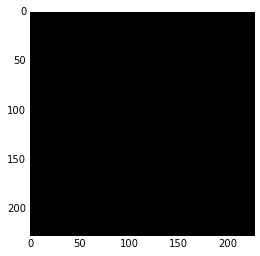

In [102]:
test_image_bgr = solver.test_nets[0].blobs['data'].data[0]
# numpy.save('test_image.npy',test_image_bgr)
# test_image_bgr = numpy.load('test_image.npy')
# print test_image_bgr[0]
# print test_image_bgr.shape
# test_image_bgr = test_image_bgr.transpose(2,0,1)
# print test_image_bgr.shape
# # print test_image_bgr[:,:,0]
# test_image = cv2.cvtColor(test_image_bgr, cv2.COLOR_RGB2BGR)
# plt.imshow(test_image_bgr[:,:,:],cmap='gray')
# plt.axis('off')
# print dir(solver.net)
test_image = test_image_bgr
# raw_scale
test_image /= 255
# for channel
print test_image_bgr.shape
test_image = test_image[[2,1,0],:,:]
print test_image_bgr.shape
test_image = test_image.transpose(1, 2, 0)
# plt.imshow(test_image[:,:,0])
plt.imshow(test_image)

### issue
This model is too weight for my pc, it consumed more than 2G memory on GPU, even after changing it layers.
so I stoped at draw curv line.

### Plotting the learning curve

In [2]:
import os
import subprocess
# import pandas as pd

# import matplotlib
# matplotlib.use('Agg')
# import matplotlib.pylab as plt

# plt.style.use('ggplot')


caffe_path = '/opt/caffe/'
model_log_path = '/home/colin/work/caffe_examples/dog_cat/results/alex_net_01/result.log'
learning_curve_path = ''

#Get directory where the model logs is saved, and move to it
model_log_dir_path = os.path.dirname(model_log_path)
# os.chdir(model_log_dir_path)

command = caffe_path + 'tools/extra/parse_log.sh ' + model_log_path
process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
process.wait()

# or just run
# /opt/caffe/tools/extra/parse_log.sh ./result.log


0

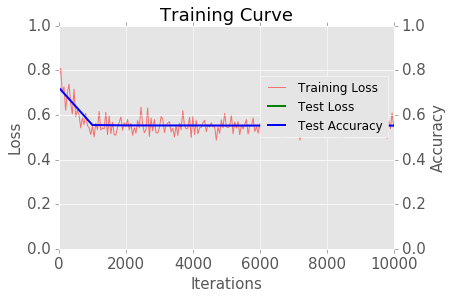

In [3]:
import pandas as pd


import matplotlib
matplotlib.use('Agg')

%matplotlib inline

import matplotlib.pylab as plt

plt.style.use('ggplot')

model_log_path= '/home/colin/work/caffe_examples/dog_cat/results/alex_net_01/result.log'
train_log_path = model_log_path + '.train'
test_log_path = model_log_path + '.test'
train_log = pd.read_csv(train_log_path, delim_whitespace=True)
test_log = pd.read_csv(test_log_path, delim_whitespace=True)

'''
Making learning curve
'''
fig, ax1 = plt.subplots()

#Plotting training and test losses
train_loss, = ax1.plot(train_log['#Iters'], train_log['TrainingLoss'], color='red',  alpha=.5)
test_loss, = ax1.plot(test_log['#Iters'], test_log['TestLoss'], linewidth=2, color='green')
ax1.set_ylim(ymin=0, ymax=1)
ax1.set_xlabel('Iterations', fontsize=15)
ax1.set_ylabel('Loss', fontsize=15)
ax1.tick_params(labelsize=15)
#Plotting test accuracy
ax2 = ax1.twinx()
test_accuracy, = ax2.plot(test_log['#Iters'], test_log['TestAccuracy'], linewidth=2, color='blue')
ax2.set_ylim(ymin=0, ymax=1)
ax2.set_ylabel('Accuracy', fontsize=15)
ax2.tick_params(labelsize=15)
#Adding legend
plt.legend([train_loss, test_loss, test_accuracy], ['Training Loss', 'Test Loss', 'Test Accuracy'],  bbox_to_anchor=(1, 0.8))
plt.title('Training Curve', fontsize=18)
#Saving learning curve
# plt.savefig(learning_curve_path)

## Building a Cat/Dog Classifier using Transfer Learning
http://cs231n.github.io/transfer-learning/
    
* Utilize the trained model as a fixed feature extractor: In this strategy, we remove the last fully connected layer from the trained model, we freeze the weights of the remaining layers, and we train a machine learning classifier on the output of the remaining layers
    
* Fine-tune the trained model: In this strategy, we fine tune the trained model on the new dataset by continuing the backpropagation. We can either fine-tune the whole network or freeze some of its layers.
    

### Download trained bvlc_reference_caffenet model

In [ ]:
# bash
# wget http://dl.caffe.berkeleyvision.org/bvlc_reference_caffenet.caffemodel
